In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import random
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [2]:
dataset_path = "archive_oc_image/dataset/semantic_drone_dataset"

# Configurable dimensions: Update these based on your requirement or config 
config_width = 256 
config_height = 128
config_classes = 32

def read_image(x):  
    x = cv2.imread(x, cv2.IMREAD_COLOR)  
    x = cv2.resize(x, (config_width, config_height))  
    x = x/255.0  
    x = x.astype(np.float32)  
    return x  
  
def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (config_width, config_height))  
    x = x.astype(np.int32)  
    return x  

def tf_dataset(x,y, batch=4):
    dataset = tf.data.Dataset.from_tensor_slices((x,y)) # Dataset data object created from input and target data
    dataset = dataset.shuffle(buffer_size=100) ## selected from the first 100 samples
    dataset = dataset.map(preprocess) # Applying preprocessing to every batch in the Dataset object
    dataset = dataset.batch(batch) # Determine batch-size
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2) # Optimization to reduce waiting time on each object
    return dataset
        

def preprocess(x,y):
    def f(x,y):
        x = x.decode() ##byte stream conversion
        y = y.decode()
        image = read_image(x)
        mask = read_mask(y)
        return image, mask
    
    image, mask = tf.numpy_function(f,[x,y],[tf.float32, tf.int32])
    mask = tf.one_hot(mask, config_classes, dtype=tf.int32)
    
    image.set_shape([config_height, config_width, 3])    
    mask.set_shape([config_height, config_width, config_classes])
    
    return image, mask

root_dir = dataset_path
img_path = root_dir + '/original_images/'
mask_path = root_dir + '/label_images_semantic/'

names = list(map(lambda x: x.replace('.png', ''), os.listdir(img_path)))

X_trainval, X_test = train_test_split(names, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.2, random_state=19)

print(f"Train Size : {len(X_train)} images")
print(f"Val Size   :  {len(X_val)} images")
print(f"Test Size  :  {len(X_test)} images")

y_train = X_train
y_test = X_test
y_val = X_val

img_train = [os.path.join(img_path, f"{name}.png") for name in X_train]
mask_train = [os.path.join(mask_path, f"{name}.png") for name in y_train]
img_val = [os.path.join(img_path, f"{name}.png") for name in X_val]
mask_val = [os.path.join(mask_path, f"{name}.png") for name in y_val]
img_test = [os.path.join(img_path, f"{name}.png") for name in X_test]
mask_test = [os.path.join(mask_path, f"{name}.png") for name in y_test]

batch_size=3

train_dataset = tf_dataset(img_train, mask_train, batch = batch_size)
valid_dataset = tf_dataset(img_val, mask_val, batch = batch_size)

train_steps = len(img_train)//batch_size
valid_steps = len(img_val)//batch_size

def test_dataset(x, batch=32):
    dataset = tf.data.Dataset.from_tensor_slices(x)
    dataset = dataset.map(preprocess_test)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset
        

def preprocess_test(x):
    def f(x):
        x = x.decode()
        image = read_image(x)
        return image
    
    image = tf.convert_to_tensor(tf.numpy_function(f, [x] , [tf.float32]))
    image = tf.reshape(image, (config_height, config_width, 3))  
    return image



def multi_unet_model(n_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.1)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    model.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy'])
    
    model.summary()
    
    return model


model = multi_unet_model(n_classes=config_classes, IMG_HEIGHT=config_height, IMG_WIDTH=config_width, IMG_CHANNELS=3)

es = tf.keras.callbacks.EarlyStopping(min_delta=0.001, patience=5)
history = model.fit(train_dataset,
          steps_per_epoch=train_steps,
          validation_data=valid_dataset,
          validation_steps=valid_steps,
          epochs=50
         )

Train Size : 194 images
Val Size   :  49 images
Test Size  :  27 images


2024-02-25 17:48:31.320124: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-02-25 17:48:31.320142: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-02-25 17:48:31.320176: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-02-25 17:48:31.320206: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-25 17:48:31.320225: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 128, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

2024-02-25 17:48:32.313608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 12s 165ms/step - loss: 2.6967 - accuracy: 0.3468 - val_loss: 1.9775 - val_accuracy: 0.5270
Epoch 2/50
64/64 [==============================] - 11s 162ms/step - loss: 1.7802 - accuracy: 0.5213 - val_loss: 1.6279 - val_accuracy: 0.4763
Epoch 3/50
64/64 [==============================] - 11s 167ms/step - loss: 1.5515 - accuracy: 0.5225 - val_loss: 1.4442 - val_accuracy: 0.5299
Epoch 4/50
64/64 [==============================] - 10s 166ms/step - loss: 1.3560 - accuracy: 0.5645 - val_loss: 1.2927 - val_accuracy: 0.5761
Epoch 5/50
64/64 [==============================] - 11s 166ms/step - loss: 1.2534 - accuracy: 0.6058 - val_loss: 1.2514 - val_accuracy: 0.6014
Epoch 6/50
64/64 [==============================] - 11s 166ms/step - loss: 1.1887 - accuracy: 0.6351 - val_loss: 1.1550 - val_accuracy: 0.6534
Epoch 7/50
64/64 [==============================] - 10s 164ms/step - loss: 1.0902 - accuracy: 0.6660 - val_loss: 1.0718 - val_accuracy: 0.6660
Epoch 8/50

10/10 [==============================] - 0s 28ms/step


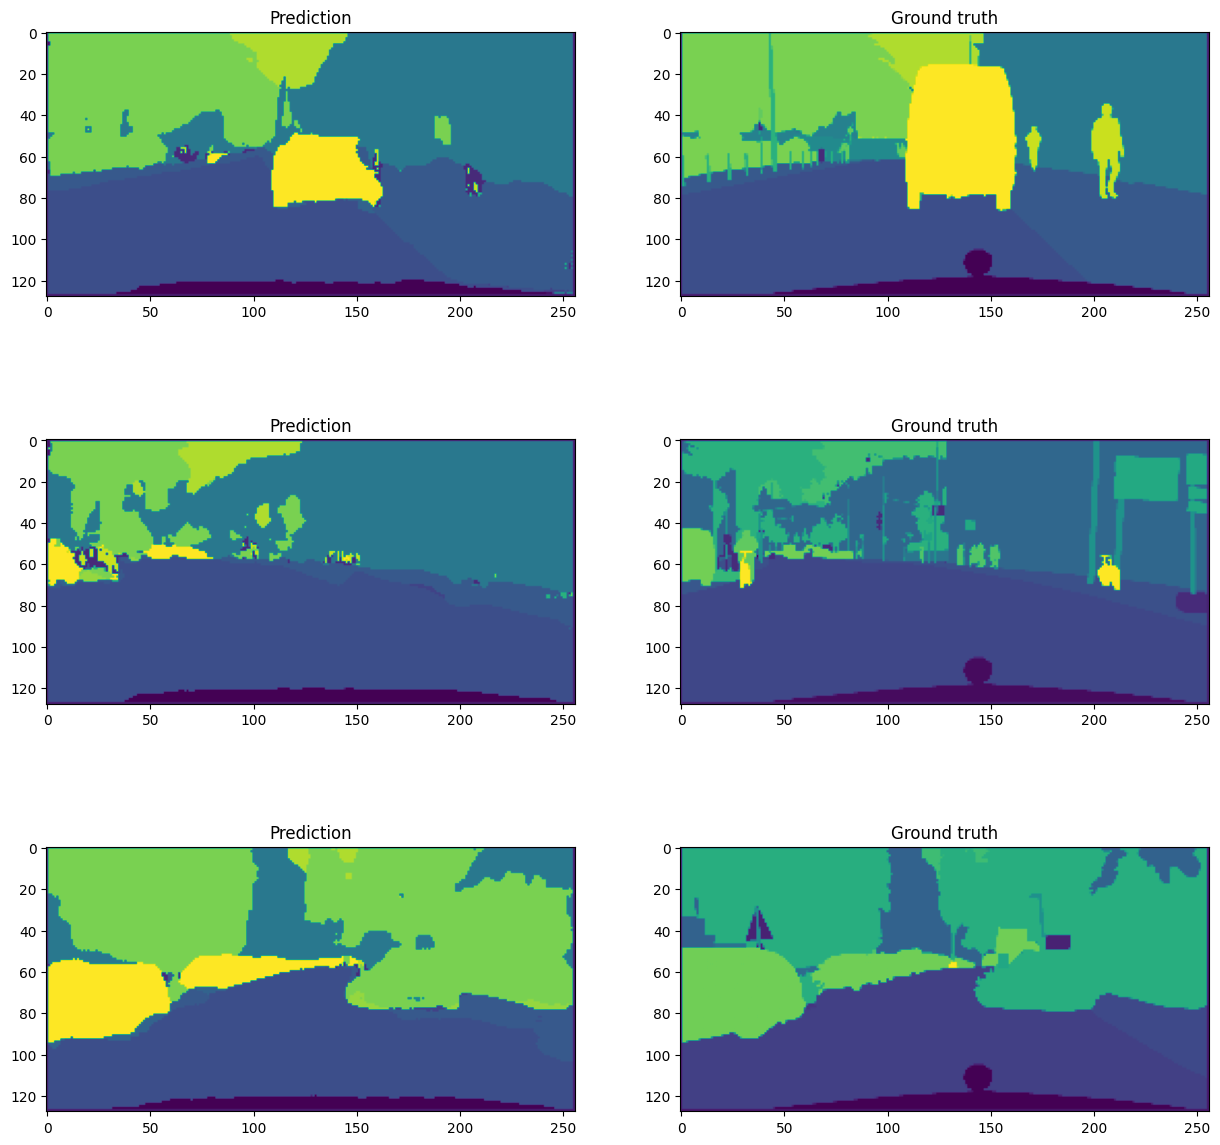

In [3]:
test_ds = tf_dataset(img_test, mask_test, batch = batch_size)
model.evaluate(test_ds, steps=14)
pred = model.predict(test_dataset(img_test, batch = 1), steps=10)

predictions = np.argmax(pred, axis=3)
label = np.array([cv2.resize(cv2.imread(mask_path+img_test[i][-8:-4]+'.png')[:, :, 0], (config_width, config_height)) for i in range(predictions.shape[0])])  
label = label.flatten()
predictions = predictions.flatten()

predictions = predictions.reshape(-1, config_height, config_width)  
label = label.reshape(-1, config_height, config_width)  

i = 3

fig, ax = plt.subplots(3, 2, figsize=(15, 15))
for j in range(3):
    ax[j, 0].imshow(predictions[i+j], cmap="viridis")
    ax[j, 1].imshow(label[i+j], cmap="viridis")
    ax[j, 0].set_title('Prediction')
    ax[j, 1].set_title('Ground truth')
    ax[j, 0].grid(False)
    ax[j, 1].grid(False)
    
plt.show()

1/1 [==============================] - 0s 14ms/step


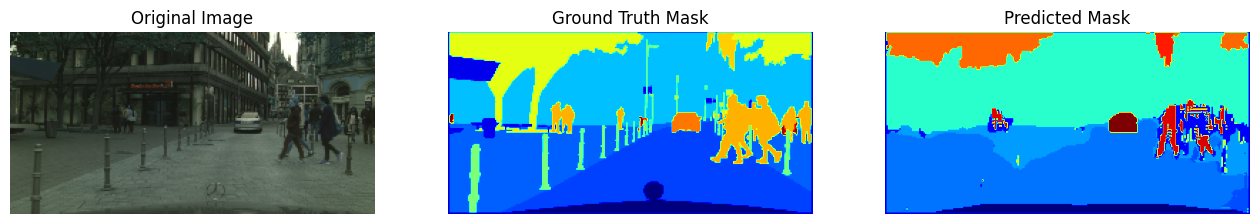

Accuracy: 68.27%


In [4]:
def predict_and_display_image_with_accuracy(image_path, truth_mask_path, model):  
    # Load and preprocess the image  
    image = read_image(image_path)  
    image_to_predict = np.expand_dims(image, axis=0)  # Add batch dimension  
      
    # Load and preprocess the truth mask  
    truth_mask = read_mask(truth_mask_path)  # Using the read_mask function defined earlier  
    truth_mask_resized = cv2.resize(truth_mask, (model.input_shape[2], model.input_shape[1]), interpolation=cv2.INTER_NEAREST)  # Resizing to match the model's input  
  
    # Predict the mask using the model  
    prediction = model.predict(image_to_predict)  
    predicted_mask = tf.argmax(prediction, axis=-1)[0]  # Remove batch dimension and convert prediction to class labels  
  
    # Calculate accuracy  
    accuracy = np.mean(predicted_mask == truth_mask_resized)  # Assumes truth_mask is already an int32 numpy array of labels  
  
    # Display the original image, the predicted mask, and print accuracy  
    plt.figure(figsize=(16, 6))  
      
    plt.subplot(1, 3, 1)  
    plt.title('Original Image')  
    plt.imshow(image)  
    plt.axis('off')  
      
    plt.subplot(1, 3, 2)  
    plt.title('Ground Truth Mask')  
    plt.imshow(truth_mask_resized, cmap='jet')  
    plt.axis('off')  
  
    plt.subplot(1, 3, 3)  
    plt.title('Predicted Mask')  
    plt.imshow(predicted_mask, cmap='jet')  
    plt.axis('off')  
      
    plt.show()  
  
    print(f"Accuracy: {accuracy*100:.2f}%")  
    
predict_and_display_image_with_accuracy(img_test[1],mask_test[1], model)

In [5]:
mask_test

['archive_oc_image/dataset/semantic_drone_dataset/label_images_semantic/0145.png',
 'archive_oc_image/dataset/semantic_drone_dataset/label_images_semantic/0018.png',
 'archive_oc_image/dataset/semantic_drone_dataset/label_images_semantic/0133.png',
 'archive_oc_image/dataset/semantic_drone_dataset/label_images_semantic/0174.png',
 'archive_oc_image/dataset/semantic_drone_dataset/label_images_semantic/0065.png',
 'archive_oc_image/dataset/semantic_drone_dataset/label_images_semantic/0136.png',
 'archive_oc_image/dataset/semantic_drone_dataset/label_images_semantic/0131.png',
 'archive_oc_image/dataset/semantic_drone_dataset/label_images_semantic/0102.png',
 'archive_oc_image/dataset/semantic_drone_dataset/label_images_semantic/0126.png',
 'archive_oc_image/dataset/semantic_drone_dataset/label_images_semantic/0202.png',
 'archive_oc_image/dataset/semantic_drone_dataset/label_images_semantic/0123.png',
 'archive_oc_image/dataset/semantic_drone_dataset/label_images_semantic/0031.png',
 'ar

In [6]:
# model.save("model_v3_full.h5")

/Users/m/dev/experiments/seg/unet/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
